#  Prediction of taxi orders

## Project work plan 

### 1. Research Objective and Plan

We analyze the historical data on airport taxi orders. To attract more drivers during peak times, there is a task to predict the number of taxi orders for the next hour. The goal of current research be  to build a model that provides such predictions.

**Research plan:**
1. Load and prepare data 
2. Analyzing data 
3. Training different models with various hyperparameters using RandomForest, Linear Regression and LightGBM
4. Testing the models on test data set

**Data:** 
We have the dataset `taxi.csv` which contains dates and the number of taxi orders for 2018 from March to August. 

## Data preparation

### Importing libraries


In [7]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (train_test_split,
                                    RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



### Raeding files

Here we read the csv file seeting the date column as an index and parsing it to datetime format 

In [10]:
pth1_taxi = 'taxi.csv'
pth2_taxi = '/datasets/taxi.csv'

if os.path.exists(pth1_taxi):
    df_taxi = pd.read_csv(pth1_taxi, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2_taxi):
    df_taxi = pd.read_csv(pth2_taxi, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong with taxi.csv')

In [11]:
df_taxi.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [12]:
df_taxi.tail(2)

,num_orders
datetime,
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


We can observe the dataset contains data for 2018 from March to August 

In [14]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


-  the dataset contains 26496 observations and two columns
-  no missing values
-  column datetime has a object type, has to be converted to datetime format

Lets convert datetime to datetime format and set index for datetime column for consistency 

Now we check if data is sorted chronologically

In [18]:
df_taxi = df_taxi.sort_index()
print(df_taxi.index.is_monotonic_increasing)


True


For the model training we do the resampling of the data by 1-h frequency 

In [20]:
df_taxi = df_taxi.resample('1H').sum()

## Exploratory data analysis 

### Visialization  of time series 

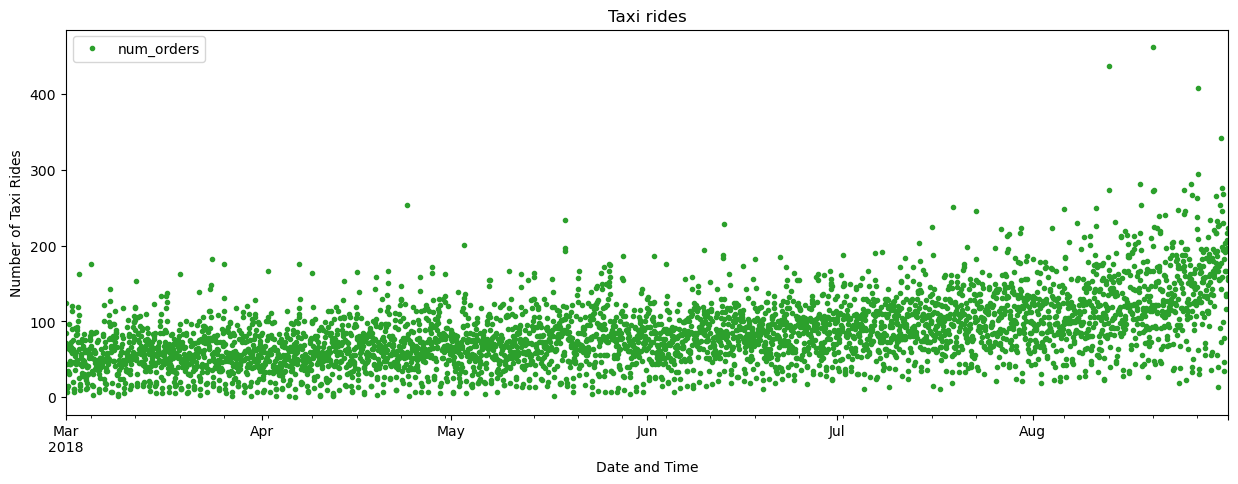

In [23]:
df_taxi.plot(style = '.', figsize = (15,5), color = color_pal[2], title = 'Taxi rides') 

plt.xlabel('Date and Time')
plt.ylabel('Number of Taxi Rides')
plt.show()

- On the graph we can observe distribution  of the number of rides from March to August of 2018


### Trend and seasonality analysis 

Now we check trend and seasonality 

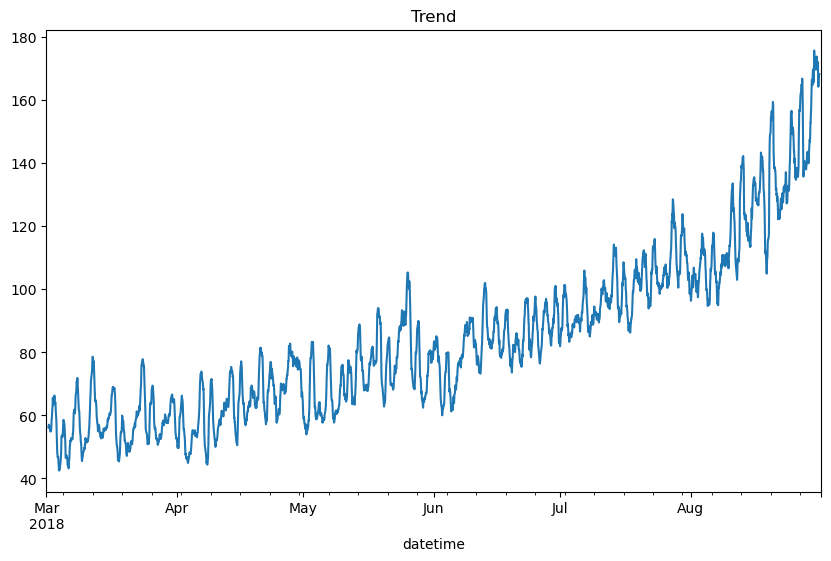

In [27]:
decomposed = seasonal_decompose(df_taxi['num_orders'], model='additive')
decomposed.trend.plot(figsize=(10, 6),title='Trend')
plt.show()


**Trend**: The graph shows an accelerating trend where the number of taxi orders increases from March to August. Initially, the trend grows slowly, but it picks up speed, especially between July and August. This indicates that the number of taxi orders sharply increases during the summer, with a particularly noticeable spike in August.

Let's examine the daily seasonality from August 1st to August 5th.

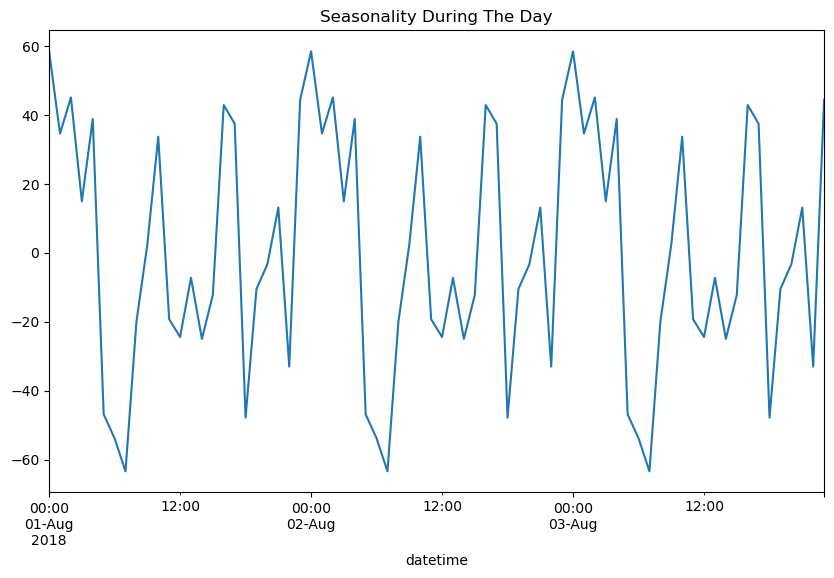

In [30]:
timeline = df_taxi['2018-08-01':'2018-08-03']
resampled_timeline = timeline.resample('1H').sum()
decomposed_day = seasonal_decompose(resampled_timeline['num_orders'], model='additive')

decomposed_day.seasonal.plot(figsize=(10, 6), title='Seasonality During The Day')
plt.show()


On the daily seasonality graph for several days, we can observe a clear pattern. There are peaks around midnight, midday (closer to 12:00), and in the evening around 17:00-18:00. These peaks likely correspond to times when people are commuting to and from work, as well as during the night, when people are likely returning home.

Next it makes sense to examine weekly seasonality as well. Lets take few weeks in July 

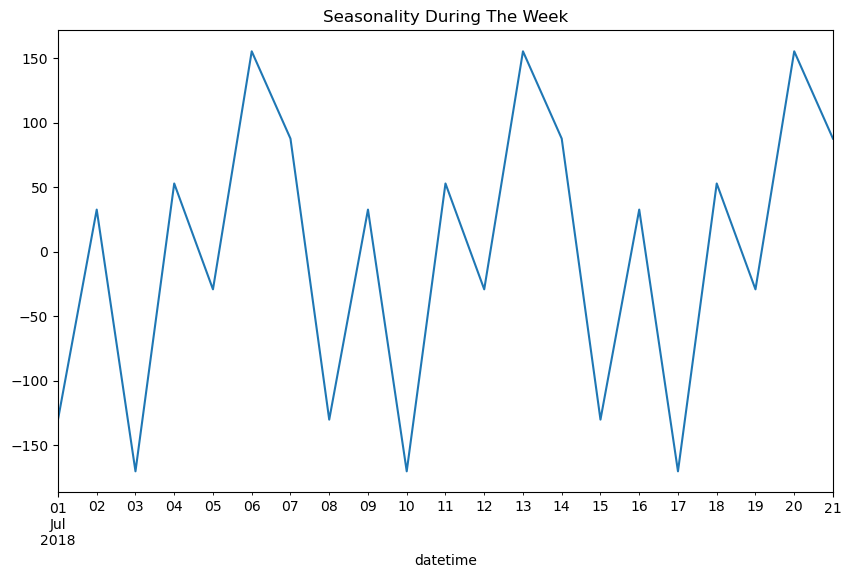

In [33]:
timeline = df_taxi['2018-07-01':'2018-07-21']
resampled_timeline = timeline.resample('1D').sum()
decomposed_week = seasonal_decompose(resampled_timeline['num_orders'], model='additive')

decomposed_week.seasonal.plot(figsize=(10, 6), title='Seasonality During The Week')
plt.show()

In the graph over a period of three weeks, a clear seasonality can be observed, where the number of trips sharply increases every Friday and Saturday

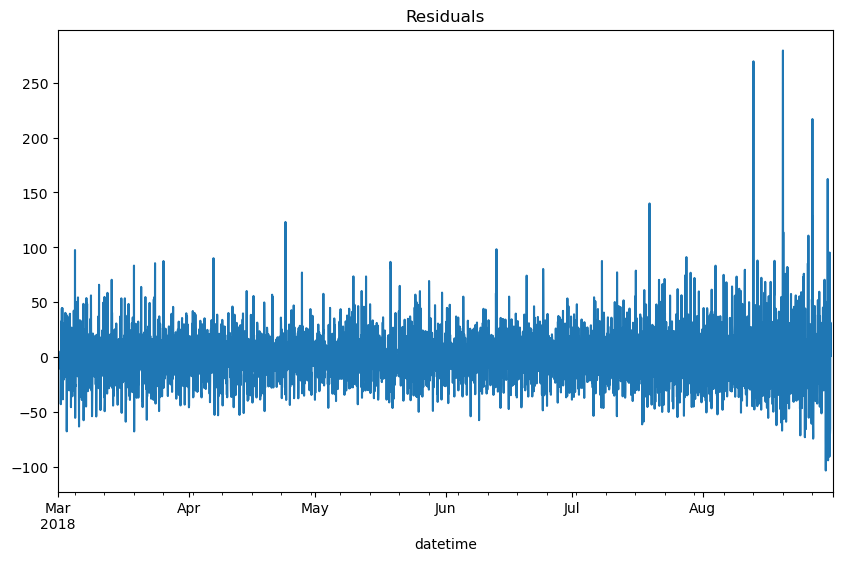

In [35]:
decomposed = seasonal_decompose(df_taxi['num_orders'], model='additive')
decomposed.resid.plot(figsize=(10, 6), title='Residuals')
plt.show()


The proportion of noise increases towards the end of the graph, indicating that more difficult-to-predict data will be included in the test set. As a result, the metrics between the training and test sets may differ.

## Model training 

### Feature creation

Let’s create a function that generates features such as day, hour, and day of the week in order to extract the feature of whether it is a weekend or not

In [41]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df.dropna() 

df_taxi = make_features(df_taxi, 10, 1)
df_taxi.head(2)


,num_orders,day,dayofweek,hour,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,1,3,10,0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.0
2018-03-01 11:00:00,96,1,3,11,0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,64.0


### Prepare data 

In [46]:
train_size = int(len(df_taxi) * 0.9)

#split the data 
train = df_taxi[:train_size]  
test = df_taxi[train_size:]  


print(f'Training set size: {len(train)}')
print(f'Test set size: {len(test)}')

Training set size: 3965
Test set size: 441


In [47]:
features = ['day','hour', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10','rolling_mean']
target = 'num_orders'

In [48]:
X_train = train[features].dropna()
y_train = train[target]
X_test = test[features]
y_test = test[target][X_test.index] 

In [49]:
numerical_features =  ['day','hour', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10','rolling_mean']

For model training we use three techniques: 
- Random Forest
- LightGBM 
- Linear Regressor

In [51]:
tscv = TimeSeriesSplit(n_splits=5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
        ]
)

pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', LinearRegression())
]   
)

param_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [50, 80, 100],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    {
        'model': [LGBMRegressor()],
        'model__n_estimators': [50, 80, 100],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [5, 10, 15],
        'model__num_leaves': [10, 20, 30]
    },
    {
        'model': [LinearRegression()]
    }
]

### Model training 

In this part we choose best model based on training set and check RMSE metrics

In [57]:
scorer = 'neg_root_mean_squared_error'
random_search = RandomizedSearchCV(
    pipe,  
    param_distributions=param_grid,  
    n_iter=10,  
    cv=tscv,  
    scoring=scorer,  
    n_jobs=-1,  
    random_state=42  
)

In [58]:
random_search.fit(X_train, y_train) 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 3965, number of used features: 14
[LightGBM] [Info] Start training from score 78.361665


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['day',
                                                                                'hour',
                                                                                'is_weekend',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'rolling_mean'])])),
                                             ('model', LinearRegression())]),
                   n_...
                                         'model__max_depth': [5, 10, 15],
                                         'model__min_samples_leaf': [1, 2],
                                         'model__min_samples_split': [2, 5],
                                         'model__n_estimators': [50, 80, 100]},
                                        {'model': [LGBMRegressor()],
                                         'model__learning_rate': [0.01, 0.05,
                                                                  0.1],
                                         'model__max_depth': [5, 10, 15],
                                         'model__n_estimators': [50, 80, 100],
                                         'model__num_leaves': [10, 20, 30]},
                                        {'model': [LinearRegression()]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [59]:
print(f"Best Model: {random_search.best_estimator_}")

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['day', 'hour', 'is_weekend',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10',
                                                   'rolling_mean'])])),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=15,
                               num_leaves=30))])


In [60]:
best_score = -1 * random_search.best_score_
print('Best model metric', best_score)

Best model metric 25.89960551786633


Best model based on hyperparameter tuning is **LGBMRegressor** with **RMSE metric 25.7**

## Тестирование

Lets run the model on test data set 

In [65]:
y_pred = random_search.best_estimator_.predict(X_test)

In [66]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

Test RMSE: 45.23988479094336


RMSE on test data is 45.2

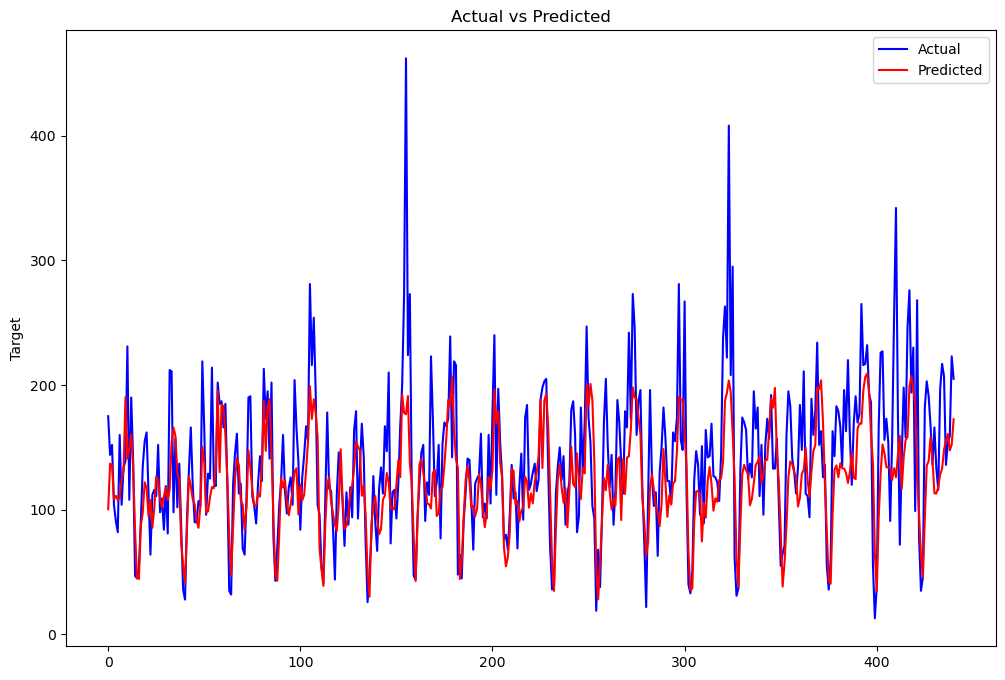

In [71]:
plt.figure(figsize=(12, 8))

plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.ylabel('Target')
plt.title('Actual vs Predicted')

plt.legend()
plt.show()


From the comparison graph of actual values and predictions, it can be observed that the model performs well with predictions for small or medium taxi demand. However, it struggles with predicting peak values. It is clearly visible that for the two highest peaks, the model significantly underestimates the predicted values